In [1]:
import pandas as pd
import glob
import os
import ast

# ==========================================
# 1. SETUP & DATA
# ==========================================
# df = pd.read_csv('your_file.csv') 
# ------------------------------------------------------------
 
# file = "all-results-for-mcu2.csv"

# collect all csv files in the directory
csv_files = glob.glob("*.csv")

dfs=[]
for file in csv_files:
    df = pd.read_csv(file)
    df.drop(columns=['total_cost','prompt_cost','completion_cost','category','test_date'], inplace=True, errors='ignore')
    if 'run_name' in df.columns:
        df.rename(columns={'run_name': 'name'}, inplace=True)
    dfs.append(df)

og_df = pd.concat(dfs, ignore_index=True)
# og_df = pd.read_csv(file)
df = og_df

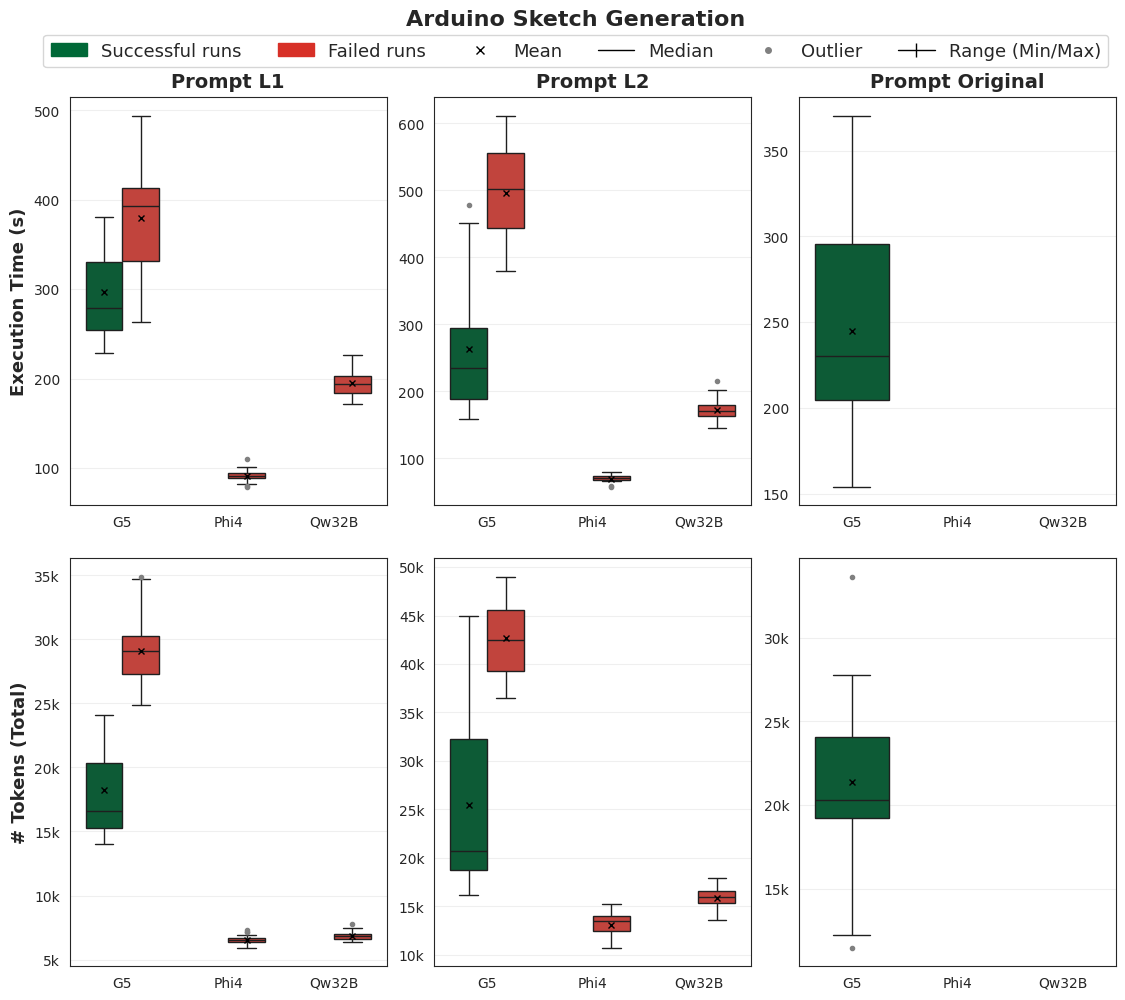

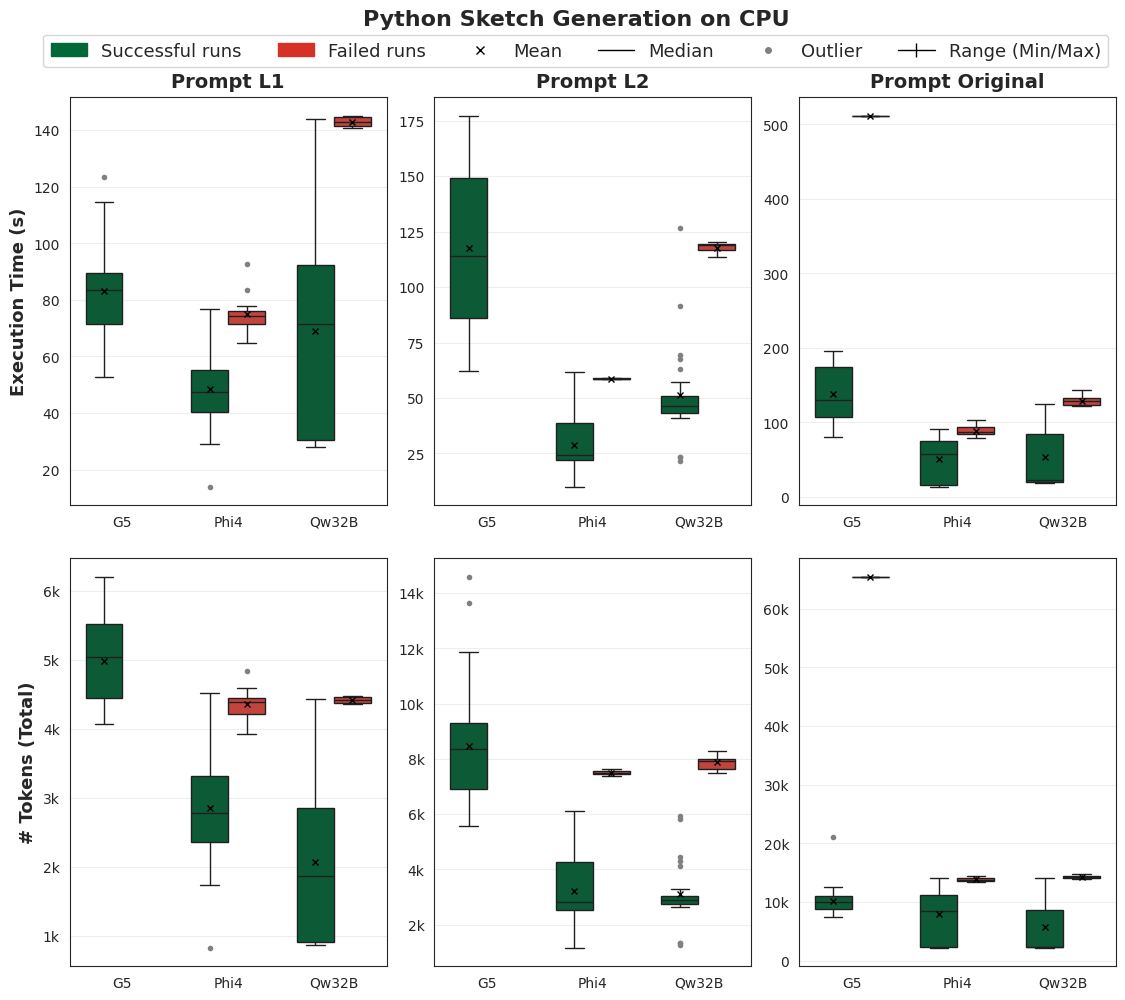

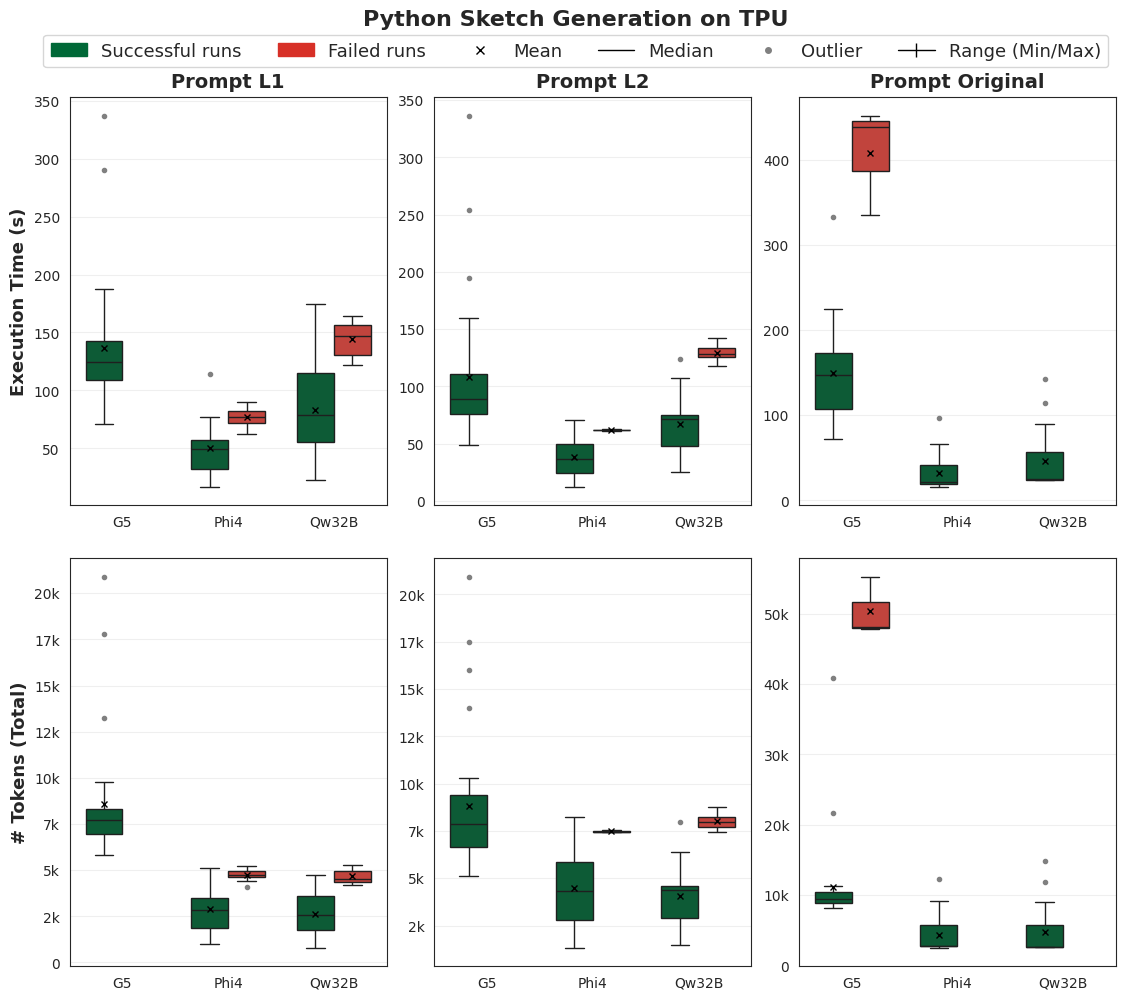

All plots generated successfully!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D  # <--- Added for custom legend handles

# ==========================================
# 2. CONFIGURATION
# ==========================================
# Mappings

# Canonical labels and ordering (single source of truth)
MODEL_LABELS = {
    "gpt-5": "G5",
    "gpt-4o": "G4o",
    "gpt-4o-mini": "G4o-m",
    "phi4": "Phi4",
    "qwen32": "Qw32B",
    "qwen14": "Qw14B",
    "gemma3": "Ge3",
    "codestral": "Co22B",
    "codestral-p": "Co22B-p",
}

proc_titles = {
    'dp': 'Data Processing', 
    'mc': 'Model Conversion', 
    'sg': 'Arduino Sketch Generation', 
    "psg": "Python Sketch Generation on CPU", 
    "tpusg": "Python Sketch Generation on TPU",
}

PROCESSOR_LABELS = { 
    "dp": "DP",
    "mc": "MC",  
    "sg": "ArdSG",
    "psg": "PySG-CPU", 
    "tpusg": "PySG-TPU",
}

# Prompt type labels and ordering
PROMPT_TYPE_LABELS = {
    "abla-l1": "Prompt L1",
    "abla-l2": "Prompt L2",
    "original": "Prompt Original"
}

# Ordering & Styling
MODEL_ORDER_PREF = list(MODEL_LABELS.keys())
PROCESSOR_ORDER_PREF = ["sg", "psg", "tpusg"]  # Only the three processors we want to plot
PROMPT_TYPE_ORDER = ["abla-l1", "abla-l2", "original"]

# Filter to only models that exist in the data and map to display names
models_in_data = [m for m in MODEL_ORDER_PREF if m in df['model'].unique()]
model_display_order = [MODEL_LABELS[m] for m in models_in_data]
 
palette = {'success': '#006837', 'failure': '#D73027'}

# Apply Map
df['model_display'] = df['model'].map(MODEL_LABELS)

# Metric Configuration
metrics = [
    {'col': 'latency',      'label': 'Execution Time (s)', 'fmt': None},
    {'col': 'total_tokens', 'label': '# Tokens (Total)',   'fmt': lambda x, p: f'{int(x/1000)}k' if x >= 1000 else f'{int(x)}'}
]

# ==========================================
# 3. PLOTTING - One figure per processor
# ==========================================
sns.set_style("white")
plt.rcParams['font.family'] = 'sans-serif'

# Define Custom Legend Elements (once for all figures)
legend_elements = [
    plt.Rectangle((0,0), 1, 1, color=palette['success'], label='Successful runs'),
    plt.Rectangle((0,0), 1, 1, color=palette['failure'], label='Failed runs'),
    Line2D([0], [0], color='black', marker='x', linestyle='None', 
           markersize=6, label='Mean'),
    Line2D([0], [0], color='black', linewidth=1, linestyle='-', 
           label='Median'),
    Line2D([0], [0], color='gray', marker='o', linestyle='None', 
           markersize=4, label='Outlier'),
    Line2D([0], [0], color='black', linewidth=1, linestyle='-', 
           marker='|', markersize=10, label='Range (Min/Max)')
]

# Create a separate figure for each processor
for proc in PROCESSOR_ORDER_PREF:
    proc_data = df[df['processor'] == proc]
    
    if proc_data.empty:
        print(f"No data for processor: {proc}")
        continue
    
    # Filter prompt types that exist in this processor's data
    prompt_types_in_data = [pt for pt in PROMPT_TYPE_ORDER if pt in proc_data['prompt_type'].unique()]
    num_prompt_types = len(prompt_types_in_data)
    
    if num_prompt_types == 0:
        print(f"No prompt types found for processor: {proc}")
        continue
    
    # Create figure: 2 rows (metrics) x num_prompt_types columns
    fig, axes = plt.subplots(nrows=2, ncols=num_prompt_types, 
                             figsize=(4.5*num_prompt_types, 11))  # Increase from 6 to 7 for wider subplots
    
    # Handle case where there's only one prompt type (axes won't be 2D)
    if num_prompt_types == 1:
        axes = axes.reshape(-1, 1)
    
    plt.subplots_adjust(top=0.90, hspace=0.13, wspace=0.15)  # Increase wspace for more horizontal spacing
    
    # Add main title for the processor
    fig.suptitle(proc_titles.get(proc, proc), fontsize=16, weight='bold', y=0.98)
    
    # Iterate through prompt types (columns) and metrics (rows)
    for col_idx, prompt_type in enumerate(prompt_types_in_data):
        subset = proc_data[proc_data['prompt_type'] == prompt_type]
        
        for row_idx, metric in enumerate(metrics):
            ax = axes[row_idx, col_idx]
            
            if subset.empty:
                ax.set_visible(False)
                continue

            # 1. Plot
            sns.boxplot(
                data=subset, x='model_display', y=metric['col'], hue='status',
                hue_order=['success', 'failure'], order=model_display_order,
                ax=ax, palette=palette,
                showmeans=True, 
                meanprops={"marker":"x", "markeredgecolor":"black", "markersize":5},
                flierprops={"marker":"o", "markersize":3, "markerfacecolor":"gray", "markeredgecolor":"gray"},
                width=0.7, linewidth=1.0
            )
            
            # 2. Clean up
            if ax.get_legend(): 
                ax.get_legend().remove()
            ax.set_xlabel("")
            ax.grid(axis='y', alpha=0.3)
            
            # 3. Styling
            # Y-label only on leftmost column
            ax.set_ylabel(metric['label'] if col_idx == 0 else "", fontweight='bold', fontsize=13)
            
            # Subplot title (prompt type) only on top row
            if row_idx == 0:
                ax.set_title(PROMPT_TYPE_LABELS.get(prompt_type, prompt_type), 
                           fontsize=14, weight='bold', pad=7)
            
            # Format y-axis if needed
            if metric['fmt']:
                ax.yaxis.set_major_formatter(FuncFormatter(metric['fmt']))
    
    # Add legend to each figure
    fig.legend(handles=legend_elements, loc='upper center', ncol=6, 
               bbox_to_anchor=(0.5, 0.965), fontsize=13, frameon=True)
    
    # Save figure
    plt.savefig(f"figs/box_{proc}_ablation.pdf", dpi=300, bbox_inches='tight')
    plt.show()

print("All plots generated successfully!")
